In [1]:
import sys
import os 

import numpy as np
from process_bigraph import pp


sys.path.insert(0, '..')


from biosimulator_processes.services.rest_service import BiosimulationsRestService

CobraProcess registered successfully.
CopasiProcess registered successfully.
_CopasiProcess registered successfully.
SmoldynProcess registered successfully.
TelluriumProcess registered successfully.
AmiciProcess registered successfully.
ODEComparatorProcess not available. Error: cannot import name 'fetch_sbml_file' from 'biosimulator_processes.io' (/Users/alexanderpatrie/Desktop/repos/biosimulator-processes/demos/../biosimulator_processes/io.py)
GetSbmlStep not available. Error: cannot import name 'fetch_sbml_file' from 'biosimulator_processes.io' (/Users/alexanderpatrie/Desktop/repos/biosimulator-processes/demos/../biosimulator_processes/io.py)
CompositionPlotter registered successfully.
Plotter2d registered successfully.
ODEComparatorStep registered successfully.


In [2]:
import tellurium as te 

teModel = te.loadSBMLModel('/Users/alexanderpatrie/Desktop/repos/biosimulator-processes/test_suite/examples/sbml-core/Caravagna-J-Theor-Biol-2010-tumor-suppressive-oscillations/Caravagna2010.xml')


results = teModel.simulate(0, 100.0, 1000)

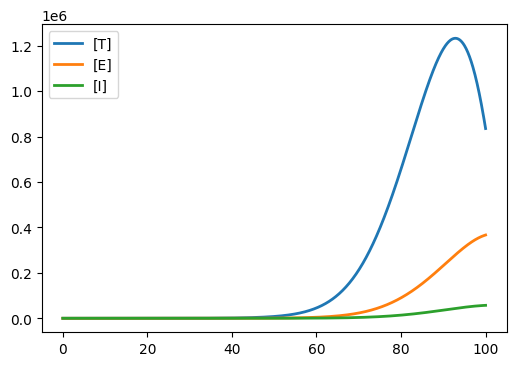

In [3]:
teModel.plot()

In [4]:
repressilator_run_id = "61fea4a08c1e3dc95a79802e"

query = "elowitz"


# TODO: Refactor this to just be able to take in an OMEX archive. 
# TODO: Load expected results json from above.


def download_simulation_report_file(url: str, save_dir=None) -> str:
    from tempfile import mkdtemp
    import requests 
    response = requests.get(url, stream=True)
    
    local_filename = "reports.h5"
    download_dir = save_dir or mkdtemp()
    fp = os.path.join(download_dir, local_filename)
    if response.status_code == 200:
        with open(fp, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192): 
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
        return fp 
    else:
        print(f"Failed to download file. Status code: {response.status_code}")


async def fetch_simulation_report_file(query: str):
    from tempfile import mkdtemp
    service = BiosimulationsRestService()
    result = await service.fetch_files(query)
    for f in result.files:
        file_url = f['url']
        if '.h5' in file_url:
            save_dir = mkdtemp()
            report_fp = download_simulation_report_file(file_url, save_dir)
            return service.read_report_outputs(report_fp)
            
            
await fetch_simulation_report_file(query)

ValueError: invalid literal for int() with base 10: ''

In [ ]:
from basico import *

model_fp = '/Users/alexanderpatrie/Desktop/repos/biosimulator-processes/demos/mtor-signaling.xml'

basicoModel = load_model(model_fp)

In [ ]:
basicoModel

In [ ]:
import requests
get_files_url = f'https://api.biosimulations.dev/results/{repressilator_run_id}/download'
headers = {'accept': 'application/json'}
files_resp = requests.get(get_files_url, headers=headers)

In [ ]:
files_resp.json()

In [ ]:
import h5py

def explore_hdf5(file_path):
    with h5py.File(file_path, 'r') as f:
        def print_attrs(name, obj):
            print(f"Name: {name}")
            print("Attributes:")
            for key, val in obj.attrs.items():
                print(f"    {key}: {val}")
            if isinstance(obj, h5py.Dataset):
                print(f"Dataset shape: {obj.shape}")
                print(f"Dataset dtype: {obj.dtype}")
            elif isinstance(obj, h5py.Group):
                print("Group")
            print()
        
        f.visititems(print_attrs)

# Usage example
file_path = '/Users/alexanderpatrie/Desktop/repos/biosimulator-processes/test_suite/examples/sbml-core/Elowitz-Nature-2000-Repressilator/reports.h5'
explore_hdf5(file_path)

In [ ]:
def read_dataset(file_path, dataset_id):
    with h5py.File(file_path, 'r') as f:
        if dataset_id in f:
            data = f[dataset_id][:]
            print(f"Data from dataset '{dataset_id}':\n{data}")
        else:
            print(f"Dataset '{dataset_id}' not found in the file.")
            
            
read_dataset(file_path, 'data_set_time')

In [ ]:
from biosimulator_processes.services.rest_service import BiosimulationsRestService

In [ ]:
from basico import * 


fp = '/Users/alexanderpatrie/Desktop/repos/biosimulator-processes/demos/BIOMD0000000012_url.xml'

model = load_model(fp)

In [ ]:
get_species(model=model)

In [ ]:
from biosimulator_processes.processes.copasi_process import CopasiProcess
group_path = 'simulation.sedml/report'
dataset_label = 'cI protein'
outputs = BiosimulationsRestService().read_report_outputs(file_path, dataset_label)




process = CopasiProcess(config={'model': {'model_source': fp}})

In [ ]:
process.inputs()[f'floating_species_concentrations']

In [ ]:
from biosimulator_processes.verify.core import verify_ode_process_outputs


verification = verify_ode_process_outputs('copasi', file_path, fp)

In [ ]:
process.initial_state()['floating_species_concentrations'].keys()

In [ ]:
def is_equal(a, b):
    return a == b or b == a  


from dataclasses import dataclass

from process_bigraph import Process


@dataclass 
class OutputAspectVerification:
    aspect_type: str  # one of: 'names', 'values'. TODO: Add more
    is_verified: bool
    

def create_ode_process_instance(process_name: str, biomodel_id=None, sbml_model_file=None) -> Process:
    module_name = f'{process_name}_process'
    import_statement = f'biosimulator_processes.processes.{module_name}'
    module_paths = module_name.split('_')
    class_name = module_paths[0].replace(module_name[0], module_name[0].upper())
    class_name += module_paths[1].replace(module_paths[1][0], module_paths[1][0].upper())
    module = __import__(
        import_statement, fromlist=[class_name])
    model_source = biomodel_id or sbml_model_file
    bigraph_class = getattr(module, class_name)
    return bigraph_class(config={'model': {'model_source':model_source}})


def verify_ode_process_output_names(process_name: str, source_report_fp: str, biomodel_id: str = None, sbml_model_file: str = None) -> OutputAspectVerification:
    # Get the class from the module
    # TODO: Automatically generate this from the biosimulations rest server
    process = create_ode_process_instance(process_name, biomodel_id, sbml_model_file)
    process_keys = list(process.inputs()['floating_species_concentrations'].keys())
    
    report_outputs = BiosimulationsRestService().read_report_outputs(report_file_path=source_report_fp)
    report_keys = [datum.dataset_label for datum in report_outputs.data]
    for i, val in enumerate(report_keys):
        if report_keys[i].lower() == 'time':
            report_keys.pop(i)
    
    return OutputAspectVerification(aspect_type='names', is_verified=is_equal(report_keys, process_keys))

In [ ]:
from biosimulator_processes.verify.core import verify_ode_process_output_names


verify_ode_process_output_names(process_name='copasi', source_report_fp=file_path, sbml_model_file=fp)

In [ ]:
x = np.array([1, 2, 3])
y = np.array([1, 2, 3.0000001])

In [ ]:
np.allclose(x, y)

In [ ]:
class TokenizedWord:
    def __init__(self, word: str, alphabet=None, language='english'):
        super().__init__()
        self.word = word
        self.alphabet = alphabet or [chr(i) for i in range(ord('a'), ord('z') + 1)]
        self.language = language
        self.data = self.tokenize()
        self.encoded = list(self.data.values())
    
    def __repr__(self):
        return repr(self.tokenize())
    
    def tokenized_word(self):
        return list(self.tokenize().values())
    
    def _create_mapping(self, data):
        return {float(i): letter for i, letter in enumerate(data)}
    
    def transform_data(self, data, r: tuple) -> np.ndarray:
        """Transform the `data` to fit range `r`, where `r=(rangeStart, rangeStop)`"""
        min_orig = min(data)
        max_orig = max(data)
        normalized_data = [a + ((x - min_orig) * (r[1] - r[0]) / (max_orig - min_orig)) for x in data]
        return np.array(normalized_data, dtype='float64')
    
    def normalize(self, data, a, z):
        min_orig = min(data)
        max_orig = max(data)
        
        # Apply min-max normalization
        normalized_data = [a + ((x - min_orig) * (z - a) / (max_orig - min_orig)) for x in data]
        return normalized_data
    
    def tokenize(self):
        # 1. create alphabet mapping (implement this for any given spoken language/music. For example, 12 tones mapped to the harmonic series
        alphabet_data = self.alphabet
        alphabet_mapping = self._create_mapping(alphabet_data)
        
        # 2. transform letter mapping range to fit 0-9, as double digits cannot be verified/read, which in python is 0, 9+1
        alphabet_index = [int(n) for n in list(alphabet_mapping.keys())]
        
        input_range = [int(min(list(alphabet_mapping.keys()))), int(max(list(alphabet_mapping.keys())))]
        start = input_range[0]
        end = input_range[1]
        transformed_letter_map_index = np.linspace(0, 9, end, dtype='float64')
    
        transformed_alphabet_mapping = dict(zip(alphabet_data, transformed_letter_map_index))
        word_letters = [letter for letter in self.word]
            
        return {
            letter: transformed_alphabet_mapping[letter]
            for letter in word_letters}
        

In [ ]:
[letter for letter in 'hello']

In [ ]:
tokenized = TokenizedWord(word='what')

tokenized.tokenized_word()

In [ ]:
tokenize_word('hello')

In [ ]:
def transform_data(data, r: tuple) -> np.ndarray:
    """Transform the `data` to fit range `r`, where `r=(rangeStart, rangeStop)`"""
    min_orig = min(data)
    max_orig = max(data)
    normalized_data = [a + ((x - min_orig) * (r[1] - r[0]) / (max_orig - min_orig)) for x in data]
    return np.array(normalized_data, dtype='float64')


# Original data
data = list(range(26))  # This generates a list [0, 1, 2, ..., 25]

# Define the target range
a = 0
z = 1

# Normalize the data
normalized_data = transform_data(data, (a, z))
print(normalized_data)

In [ ]:
# 1. User uploads an omex archive(fp) --> .
# 2. Omex is unpacked into a temp dir
# 3. report.h5 is extracted from temp dir (list of paths?)
# 3a. expected-results.json extracted from temp dir
# 4. Return dataclass from expected results json
# 5. Extract species names/dataset labels by indexing over the datasets in expected results
# 6. Use the output of #5 as an index over the report.h5 from #3.
# 7. Extract the time points data from #4 and create/infer time vector.
# 8. Use the inference from #7 as set data for both the Composite engine AND process itself (num steps).
# 9. Verify the simulation settings in process constructor(s) against ExpectedResults (#5) BEFORE running 
# 10. Run the composite from #8 if #9 passes.
# 11. Get the results from #10.
# 12. Run Comparison matrices and assert all zeros.

In [5]:
from biosimulators_utils.combine.io import CombineArchiveReader
from fastapi import FastAPI, UploadFile, File 
from fastapi.responses import StreamingResponse

# app = FastAPI()


class SourceServerExchange:
    pass 


class UploadOmexExchange(SourceServerExchange):
    app = FastAPI()
    def __init__(self, app: FastAPI = app):
        self.app = app 
        
    @app.post("/upload-omex")
    async def upload_omex(self, file: UploadFile = File(...)):
        contents = await file.read()
        path = self.save_omex_archive(contents)
        return {"filename": path}
    
    def save_omex_archive(self, contents: bytes) -> str:
        with tempfile.NamedTemporaryFile(delete=False, suffix='.omex') as temp_file:
            temp_file.write(contents)
            archive_path = temp_file.name
        return archive_path
    
    
    
    
app = FastAPI()
@app.post("/upload-omex")
async def upload_omex(file: UploadFile = File(...)):
    contents = await file.read()
    
    save_dir = tempfile.mkdtemp()
    archive_response = save_omex_archive(contents, save_dir)
    return {"filename": archive_response['source']}


def unpack_omex(archive_fp: str, save_dir: str):
    return CombineArchiveReader().run(archive_fp, save_dir)


def save_omex_archive(contents: bytes, save_dir: str):
    with tempfile.NamedTemporaryFile(delete=False, suffix='.omex') as temp_file:
        temp_file.write(contents)
        archive_path = temp_file.name
    
    return {'source': archive_path, 'archive': unpack_omex(archive_path, save_dir), 'save_dir': save_dir}

In [8]:
from biosimulator_processes.services.rest_service import BiosimulationsRestService


RUN_ID = '61fea4a08c1e3dc95a79802e'
PROJECT_NAME = 'Repressilator'


class VerifyResults:
    def __init__(self, process_address_name: str, truth_run_id: str, truth_project_name: str):
        self.process_address_name = process_address_name
        self.truth_run_project_name = truth_project_name
        self.biosim_service = BiosimulationsRestService()
        
        self.get_report_and_expected_results_from_project(truth_run_id, truth_project_name)
    
    def fetch_project_files(self, run_id: str, proj_name: str):
        return self.biosim_service.get_project_files(run_id=run_id, project_name=proj_name)
    
    def get_report_and_expected_results_from_project(self, run_id, proj_name):
        project_files = self.fetch_project_files(run_id, proj_name)
        report_file = None 
        expected_results_file = None
        
        for file in project_files.files:
            location = file['location']
            if 'expected_results' in location:
                expected_results_file = file 
            if 'report' in location:
                report_file = file 
        
        print(expected_results_file)

In [9]:
VerifyResults('copasi', RUN_ID, PROJECT_NAME)

None
